# Classification with Support Vector Machines (SVM), bank

Make non-linear transformation of data and apply LSVM.

## Index
<nav>

* [Import modules](#import_modules)
* [Loading data](#loading_data)
* [Data preprocessing](#data_preprocessing)
* [Cross validation](#cross_validation)
* [Training (fit the model)](#training)
* [Test (evaluate the model)](#test)
* [References](#references)
</nav>

<a id="import_modules"></a>
## Import modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

<a id="loading_data"></a>
## Loading data

In [3]:
# Load training data
filename1 = 'input\\A2-bank\\bank-additional.csv'
#filename1 = 'input\\A2-bank\\bank-additional-full.csv'
bank_df = pd.read_csv(filename1, delimiter=';', header=0)
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
bank_df[bank_df.isnull().any(axis=1)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


<a id="data_preprocessing"></a>
## Data preprocessing

### Input variables:

Bank client data:

1. age (numeric)
   
2. job: type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3. marital: marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5. default: has credit in default? (categorical: "no","yes","unknown")

6. housing: has housing loan? (categorical: "no","yes","unknown")

7. loan: has personal loan? (categorical: "no","yes","unknown")

related with the last contact of the current campaign:

8. contact: contact communication type (categorical: "cellular","telephone")

9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14. previous: number of contacts performed before this campaign and for this client (numeric)

15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)

17. cons.price.idx: consumer price index - monthly indicator (numeric)

18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19. euribor3m: euribor 3 month rate - daily indicator (numeric)

20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21. y - has the client subscribed a term deposit? (binary: "yes","no")

[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) can be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

In [6]:
# get all categorical columns in the dataframe
catCols = [col for col in bank_df.columns if bank_df[col].dtype=="O"]
print(catCols)

lb_make = LabelEncoder()

for item in catCols:
    bank_df[item] = lb_make.fit_transform(bank_df[item])

print(bank_df)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
      age  job  marital  education  default  housing  loan  contact  month  \
0      30    1        1          2        0        2     0        0      6   
1      39    7        2          3        0        0     0        1      6   
2      25    7        1          3        0        2     0        1      4   
3      38    7        1          2        0        1     1        1      4   
4      47    0        1          6        0        2     0        0      7   
...   ...  ...      ...        ...      ...      ...   ...      ...    ...   
4114   30    0        1          1        0        2     2        0      3   
4115   39    0        1          3        0        2     0        1      3   
4116   27    8        2          3        0        0     0        0      6   
4117   58    0        1          3        0        0     0        0      1   
4118   34    4        2     

In [7]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(bank_df)
bank_df = pd.DataFrame(x_scaled)

In [8]:
train_df, test_df = train_test_split(bank_df, test_size=0.2)
print(train_df)
print(test_df)

            0         1         2         3    4    5    6    7         8   \
3944  0.385714  0.000000  0.000000  0.428571  0.0  1.0  0.0  0.0  0.777778   
1162  0.542857  0.000000  0.333333  0.857143  0.0  1.0  0.0  0.0  0.333333   
2901  0.471429  0.090909  0.000000  1.000000  0.5  0.0  0.0  1.0  0.444444   
3514  0.185714  0.909091  0.333333  0.428571  1.0  0.0  0.0  0.0  0.777778   
460   0.428571  0.545455  0.333333  0.857143  0.5  1.0  0.0  1.0  0.666667   
...        ...       ...       ...       ...  ...  ...  ...  ...       ...   
3908  0.385714  0.818182  0.333333  0.857143  0.0  1.0  0.0  1.0  0.666667   
908   0.042857  0.727273  0.666667  0.428571  0.0  1.0  1.0  0.0  0.444444   
1220  0.542857  0.909091  0.000000  0.857143  0.5  1.0  0.0  1.0  0.666667   
1358  0.200000  0.000000  0.333333  0.428571  0.0  0.0  0.0  0.0  0.777778   
1732  0.257143  0.000000  0.666667  1.000000  0.0  0.0  0.0  0.0  0.333333   

        9   ...        11   12        13   14        15        

<a id="cross_validation"></a>
## Cross validation

Using [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) in order to find good values for all the parameters of SVM: kernel, and parameters.

K-fold ---------------------------------------------------------------
Model accuracy: 0.9101941747572816


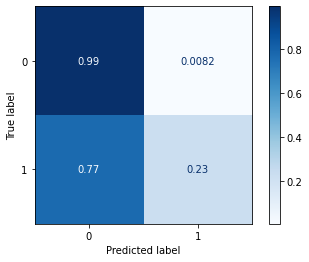

Confusion matrix:
 [[730   6]
 [ 68  20]]
Percentage classification error obtained from validation set: 8.980582524271846%
K-fold ---------------------------------------------------------------
Model accuracy: 0.9065533980582524


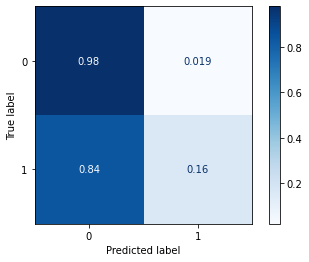

Confusion matrix:
 [[735  14]
 [ 63  12]]
Percentage classification error obtained from validation set: 9.344660194174757%
K-fold ---------------------------------------------------------------
Model accuracy: 0.8956310679611651


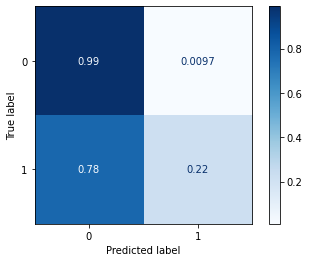

Confusion matrix:
 [[716   7]
 [ 79  22]]
Percentage classification error obtained from validation set: 10.436893203883495%
K-fold ---------------------------------------------------------------
Model accuracy: 0.8967193195625759


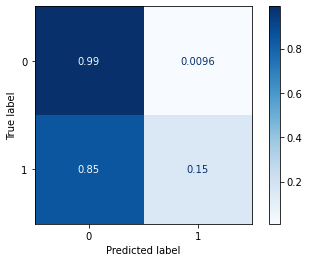

Confusion matrix:
 [[724   7]
 [ 78  14]]
Percentage classification error obtained from validation set: 10.328068043742405%
Mean percentage classification error obtained from cross validation: 9.772550991518125%


In [12]:
X_train = train_df.iloc[:,0:20].to_numpy()
y_train = train_df.iloc[:,20].astype(int).to_numpy()

cv_percentage_classification_errors = list()

# 4-fold cross-validation
kf = KFold(n_splits=4)
for train, validation in kf.split(X_train):
    print('K-fold ---------------------------------------------------------------')
    
    # Create the SVM estimator
    clf = SVC(kernel='rbf', random_state=0)
    
    # Train the model using the training set
    clf.fit(X_train[train], y_train[train])

    # Generate predictions
    y_pred = clf.predict(X_train[validation])
    
    # Evaluate by means of accuracy
    accuracy = accuracy_score(y_train[validation], y_pred)
    print(f'Model accuracy: {accuracy}')
    
    # Evaluate by means of a confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_train[validation], y_pred,
                                                   labels=clf.classes_,
                                                   display_labels=clf.classes_,
                                                   cmap=plt.cm.Blues,
                                                   normalize='true')
    plt.show()
    
    cm = confusion_matrix(y_train[validation], y_pred)
    print('Confusion matrix:\n', cm)

    # Calculate the percentage classification error obtained from validation test
    percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
    print(f'Percentage classification error obtained from validation set: {percentage_classification_error}%')
    
    cv_percentage_classification_errors.append(percentage_classification_error)
    
# Calculate the mean percentage classification error obtained from cross-validation
print(f'Mean percentage classification error obtained from cross validation: {np.mean(cv_percentage_classification_errors)}%')

<a id="training"></a>
## Training (fit the model)

In [13]:
# Create the SVM estimator
clf = SVC(kernel='rbf', random_state=0)
print('Names and current values for all parameters for the estimator: ', clf.get_params())

# Train the model using 'all' the training set
clf.fit(X_train, y_train)

Names and current values for all parameters for the estimator:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


SVC(random_state=0)

<a id="test"></a>
## Test (evaluate the model)

Model accuracy: 0.8968446601941747


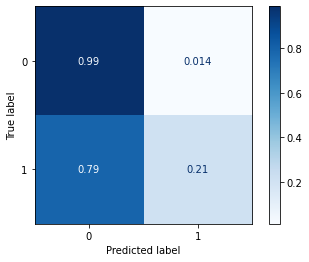

Confusion matrix:
 [[719  10]
 [ 75  20]]
Percentage classification error obtained from test set: 10.315533980582524%


In [14]:
X_test = test_df.iloc[:,0:20].to_numpy()
y_test = test_df.iloc[:,20].astype(int).to_numpy()

# Generate predictions
y_pred = clf.predict(X_test)

# Evaluate by means of accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy}')

# Evaluate by means of a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                               labels=clf.classes_,
                                               display_labels=clf.classes_,
                                               cmap=plt.cm.Blues,
                                               normalize='true')
plt.show()

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# Calculate the percentage classification error obtained from test set
percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
print(f'Percentage classification error obtained from test set: {percentage_classification_error}%')

In [15]:
bank_svm_results = { 'real_value': y_test,
                    'prediction': y_pred}
  
df = pd.DataFrame(bank_svm_results)

df.to_csv('bank_svm_results.csv')

<a id="references"></a>
## References:

Support Vector Machines:

- [A Practical Guide to Support Vector Classification](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)
- https://scikit-learn.org/stable/modules/svm.html#classification
- [Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- [How do I select SVM kernels?](https://sebastianraschka.com/faq/docs/select_svm_kernels.html)
- [RBF SVMs with Python and Scikit-learn: an Example](https://www.machinecurve.com/index.php/2020/11/25/using-radial-basis-functions-for-svms-with-python-and-scikit-learn/#:~:text=the%20RBF%20kernel.-,RBF%20SVMs%20with%20Python%20and%20Scikit%2Dlearn%3A%20an%20Example,-We%20can%20easily)
- [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

Data Visualization:

- [Seaborn Library for Data Visualization in Python: Part 1](https://stackabuse.com/seaborn-library-for-data-visualization-in-python-part-1)

Cross Validation:

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimato)
- [Parameter estimation using grid search with cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)

Data Preprocessing:

- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)